# IMPORTS

In [1]:
!pip install netCDF4 einops
import netCDF4 as nc
import numpy as np
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import time  # For timing
import matplotlib.pyplot as plt
from einops import rearrange

# FIRST PART

If already imported the tensors: x_train, x_val, x_test, y_train, y_val, y_test, don't execute this first part

# READ COMBINED FILES

In [3]:
file_path = '/kaggle/input/tensor/tensor.npy'

# Load the .npy file into a NumPy array
reshaped_data = np.load(file_path)

reshaped_data = reshaped_data[:18000]
print("Data shape:", reshaped_data.shape)

Data shape: (18000, 13, 32, 64)


# CREATE THE TIME SERIES

In [ ]:
time_steps = reshaped_data.shape[0]  # Total time steps

# Define the time step offsets
t_offsets = [0, 6, 12]  # Offsets for t, t-6h, t-12h
t_plus_24h = 24         # Offset for t+24h

X, y = [], []

# Create sequences and corresponding labels
for i in range(time_steps - t_plus_24h):
    # Input sequence: t, t-6h, t-12h
    sequence = np.concatenate([reshaped_data[i - offset] for offset in t_offsets], axis=0)
    
    if (i + t_plus_24h) < time_steps:
        if reshaped_data[i + t_plus_24h].shape[0] >= 3:
            # Select specific channels for the label
            label = np.stack([
                reshaped_data[i + t_plus_24h][2, :, :],  # 2-meter temperature
                reshaped_data[i + t_plus_24h][0, :, :],  # Geopotential at 500 hPa
                reshaped_data[i + t_plus_24h][1, :, :]   # Temperature at 850 hPa
            ], axis=0)
            
            # Append the sequence and label to the lists
            X.append(sequence)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # Expected: (num_sequences, 39, 32, 64)
print("y shape:", y.shape) 

In [ ]:
np.save('y.npy', y)
np.save('X.npy', X)
del y
del reshaped_data
X = np.load('X.npy')
y = np.load('y.npy')

In [ ]:
base_path_c = '/kaggle/input/constants/constants/constants.nc'

dataset_c = nc.Dataset(base_path_c, 'r')
oro = dataset_c.variables['orography'][:]
lat = dataset_c.variables['lat'][:]
lsm = dataset_c.variables['lsm'][:]

# Expand lat to match the shape of oro and lsm
lat_expanded = np.tile(lat[:, np.newaxis], (1, 64))

# Verify the shapes
print("Orography shape:", oro.shape)          # (32, 64)
print("Lat expanded shape:", lat_expanded.shape)  # (32, 64)
print("Land-sea mask shape:", lsm.shape)      # (32, 64)

# Expand the constants along the time dimension to match X's first dimension
oro_expanded = np.tile(oro[np.newaxis, :, :], (X.shape[0], 1, 1))
lat_expanded = np.tile(lat_expanded[np.newaxis, :, :], (X.shape[0], 1, 1))
lsm_expanded = np.tile(lsm[np.newaxis, :, :], (X.shape[0], 1, 1))

X = np.concatenate([X, oro_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lat_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lsm_expanded[:, np.newaxis, :, :]], axis=1)


del oro_expanded
del lat_expanded
del lsm_expanded

X = np.ma.filled(X, np.nan)
print("Data shape:", X.shape)

Orography shape: (32, 64)
Lat expanded shape: (32, 64)
Land-sea mask shape: (32, 64)


In [ ]:
np.save('X.npy', X)
del X
gc.collect()
X = np.load('X.npy')
y = np.load('y.npy')

# CREATE TRAIN, VAL AND TEST SET

In [ ]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# First, split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)
X, y = [], []

del X
del y

gc.collect()

# Then split the temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

# SECOND PART

In [2]:
#Run this cell
X_test = np.load('/kaggle/input/data-train-x/X_test.npy')
y_test = np.load('/kaggle/input/data-train-y/y_test.npy')
X_train = np.load('/kaggle/input/data-train-x/X_train.npy')
y_train = np.load('/kaggle/input/data-train-y/y_train.npy')
X_val = np.load('/kaggle/input/data-train-x/X_val.npy')
y_val = np.load('/kaggle/input/data-train-y/y_val.npy')

In [3]:
print(X_train.shape)

(12583, 42, 32, 64)


In [ ]:
#Run this cell
class ClimateDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        X = self.X_data[idx]
        y = self.y_data[idx]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

# CREATE LABELS OF T2M, G500 AND T850

In [61]:
#Run this cell
batch_size = 32

y_train_t2m = y_train[:, 0:1, :, :] 
y_train_g500 = y_train[:, 1:1+1, :, :]
y_train_t850 = y_train[:, 2:2+1, :, :] 

y_val_t2m = y_val[:, 0:1, :, :] 
y_val_g500 = y_val[:, 1:1+1, :, :]
y_val_t850 = y_val[:, 2:2+1, :, :]

y_test_t2m = y_test[:, 0:1, :, :] 
y_test_g500 = y_test[:, 1:1+1, :, :] 
y_test_t850 = y_test[:, 2:2+1, :, :]

train_dataset = ClimateDataset(X_train, y_train_g500)
val_dataset = ClimateDataset(X_val, y_val_g500)
test_dataset = ClimateDataset(X_test, y_test_g500)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# RESNET SIMPLIFIED

In [38]:
#Run this cell
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes= 32 * 64):
        super(ResNet, self).__init__()
        self.layer1 = nn.Conv2d(42, 64, kernel_size=7, stride=2, padding=3)  # Adjust input channels to 9
        self.bn1 = nn.BatchNorm2d(64)
        self.layer2 = self._make_layer(64, 64, stride=1)
        self.layer3 = self._make_layer(64, 128, stride=2)
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 1, 32, 64)  # Reshape to 3 channels of 32x64
        return x

# RESNET OF THE PAPER

In [36]:
#Run this cell
class PeriodicPadding(nn.Module):
    def __init__(self, padding):
        super(PeriodicPadding, self).__init__()
        self.padding = padding

    def forward(self, x):
        # Apply periodic padding on the left and right (longitude)
        x = F.pad(x, (self.padding, self.padding, 0, 0), mode='circular')
        # Apply zero padding on the top and bottom (latitude)
        x = F.pad(x, (0, 0, self.padding, self.padding), mode='constant', value=0)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = F.leaky_relu(self.bn1(out), negative_slope=0.3)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.leaky_relu(out, negative_slope=0.3)
        out = self.dropout(out)
        return out

class ResNet1(nn.Module):
    def __init__(self, num_classes=32*64, in_channels=42, num_blocks=28, hidden_dim=128, dropout_rate=0.1):
        super(ResNet1, self).__init__()
        self.periodic_padding = PeriodicPadding(padding=3)  # Padding size 3 for kernel size 7
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=7, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.residual_layers = self._make_layer(hidden_dim, hidden_dim, num_blocks, dropout_rate)
        
        self.fc = nn.Linear(hidden_dim, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, dropout_rate):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(in_channels, out_channels, dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.periodic_padding(x)
        x = self.conv1(x)
        x = F.leaky_relu(self.bn1(x), negative_slope=0.3)
        x = self.dropout(x)
        
        x = self.residual_layers(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 1, 32, 64)  # Reshape to match target dimensions
        return x

model = ResNet1(num_classes=32*64, in_channels=42, num_blocks=28, hidden_dim=128, dropout_rate=0.1)

# UNET

In [11]:
#Run this cell
class UNet(nn.Module):
    def __init__(self, in_channels=42, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            return block
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder path
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, 64)
        
        # Final layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final layer
        output = self.final_conv(dec1)
        
        return output

# VIT

In [56]:
#Run this cell
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=42, patch_size=4, emb_size=768, img_size=(32, 64)):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_size))

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x)  # Shape: [B, emb_size, H/P, W/P]
        x = rearrange(x, 'b e (h) (w) -> b (h w) e')  # Shape: [B, num_patches, emb_size]
        cls_tokens = self.cls_token.expand(B, -1, -1)  # Shape: [B, 1, emb_size]
        x = torch.cat((cls_tokens, x), dim=1)  # Shape: [B, num_patches + 1, emb_size]
        x = x + self.pos_embedding  # Add positional embedding
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.emb_size = emb_size
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.fc = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)  # Shape: [B, N, 3 * emb_size]
        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # Shape: [3, B, num_heads, N, emb_size // num_heads]
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(C // self.num_heads, dtype=torch.float32)))
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.fc(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, mlp_dim=1024, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, in_channels=42, num_classes=1, emb_size=768, num_layers=12, num_heads=8, mlp_dim=1024, patch_size=4, img_size=(32, 64), dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.transformer = nn.Sequential(
            *[TransformerBlock(emb_size, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )
        self.norm = nn.LayerNorm(emb_size)
        self.fc = nn.Linear(emb_size, num_classes * img_size[0] * img_size[1])  # num_classes set to 1

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]  # Use the cls_token for classification/regression
        x = self.fc(x)
        x = x.view(x.size(0), 1, 32, 64)  # Reshape to [B, 1, 32, 64] for one feature
        return x

# LOSS FUNCTION

In [9]:
#Run this cell
def latitude_weighting(latitudes):
    L = torch.cos(torch.deg2rad(latitudes))
    L /= L.sum() * 32  # Normalize so that the weights sum to 1
    return L

# Latitude-weighted RMSE calculation
def latitude_weighted_rmse(y_true, y_pred, latitudes):
    L = latitude_weighting(latitudes).to(y_true.device)  # Shape: (H,)
    L = L[None, None, :, None]  # Shape: (1, 1, H, 1)

    # Compute the difference and apply latitude weighting
    diff = y_pred - y_true  # Shape: (batch_size, channels, H, W)
    #print(diff.shape)
    weighted_mse = torch.sum(torch.sum(L * (diff ** 2), dim=2),dim=2) /  (y_true.size(2) * y_true.size(3))

    # Calculate RMSE
    rmse = (1/y_true.size(0)) * torch.sum(torch.sqrt(weighted_mse),dim=0)

    return rmse

def anomaly_correlation_coefficient(y_true, y_pred, latitudes):
    L = latitude_weighting(latitudes).to(y_true.device)  # Shape: (H,)
    L = L[None, None, :, None]  # Reshape to match (batch_size, channels, H, W)

    # Calculate anomalies
    y_true_mean = torch.mean(y_true, dim=0, keepdim=True)
    y_true_anomaly = y_true - y_true_mean
    y_pred_anomaly = y_pred - y_true_mean

    # Numerator and denominator for ACC
    numerator = torch.sum(L * y_true_anomaly * y_pred_anomaly)
    denominator = torch.sqrt(torch.sum(L * y_true_anomaly ** 2) * torch.sum(L * y_pred_anomaly ** 2))

    acc = numerator / denominator

    return acc

In [12]:
#Run this cell
# Set up the model, optimizer, and scheduler
# Select the model you want to train by comment all the other models, in this example we have a model for UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = ResNet1()
#model = ResNet()
model = UNet().to(device)
#model = VisionTransformer().to(device)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1 if epoch >= 95 else 1.0)

In [13]:
#Run this cell
class WarmUpLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, total_epochs, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        super(WarmUpLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            return [base_lr * (epoch + 1) / self.warmup_epochs for base_lr in self.base_lrs]
        else:
            return [base_lr * 0.5 * (1 + np.cos(np.pi * (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)))
                    for base_lr in self.base_lrs]

warmup_epochs = 5
total_epochs = 100
scheduler = WarmUpLR(optimizer, warmup_epochs, total_epochs)

In [23]:
#Run this cell if you want to start the training, otherwise you have to import the pre-trained models and run another code downbelow

def train_epoch(model, dataloader, criterion, optimizer, latitudes, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for inputs, labels in tqdm(dataloader, desc="Training Epoch", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = latitude_weighted_rmse(labels, outputs, latitudes)
        loss.backward()
        optimizer.step()

        acc = anomaly_correlation_coefficient(labels, outputs, latitudes)
        running_loss += loss.item() * inputs.size(0)
        running_acc += acc.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, latitudes, device):
    model.eval()
    running_loss = 0.0
    running_rmse = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            rmse = latitude_weighted_rmse(labels, outputs, latitudes)

            acc = anomaly_correlation_coefficient(labels, outputs, latitudes)

            running_loss += loss.item() * inputs.size(0)
            running_rmse += rmse.item() * inputs.size(0)
            running_acc += acc.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_rmse = running_rmse / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_rmse, epoch_acc

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100, patience=5, device='cpu'):
    best_val_rmse = float('inf')
    patience_counter = 0

    latitudes = torch.arange(-87.1875, 92.8125, 180 / 32).to(device)  # Assuming 32 latitude points; adjust if necessary

    # Lists to store training and validation losses for each epoch
    train_losses = []
    val_losses = []

    # Start timing the entire training process
    start_time = time.time()

    for epoch in range(num_epochs):
        # Train for one epoch and get both loss and ACC
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, latitudes, device)
        train_losses.append(train_loss)

        # Evaluate on the validation set
        val_loss, val_rmse, val_acc = evaluate(model, val_loader, criterion, latitudes, device)
        val_losses.append(val_rmse)

        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train ACC: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val RMSE: {val_rmse:.4f} - Val ACC: {val_acc:.4f}")

        # Check for early stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Load the best model for testing
    model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

    # Evaluate on the test set
    test_loss, test_rmse, test_acc = evaluate(model, test_loader, criterion, latitudes, device)
    print(f"Test Loss: {test_loss:.4f} - Test RMSE: {test_rmse:.4f} - Test ACC: {test_acc:.4f}")

    # Calculate and print the total training time
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f} seconds")

    # Plot the loss graph
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 1/1000 - Train Loss: 1737.2840 - Train ACC: -0.0000 - Val Loss: 2940009753.0682 - Val RMSE: 1736.7915 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 2/1000 - Train Loss: 1735.2232 - Train ACC: -0.0000 - Val Loss: 2928807250.8012 - Val RMSE: 1733.5553 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 3/1000 - Train Loss: 1729.9147 - Train ACC: -0.0000 - Val Loss: 2902108105.3056 - Val RMSE: 1725.8183 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.01batch/s]


Epoch 4/1000 - Train Loss: 1718.4268 - Train ACC: -0.0000 - Val Loss: 2848285370.8724 - Val RMSE: 1710.1128 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.06batch/s]


Epoch 5/1000 - Train Loss: 1696.8823 - Train ACC: -0.0000 - Val Loss: 2753849436.6766 - Val RMSE: 1682.1928 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.06batch/s]


Epoch 6/1000 - Train Loss: 1664.8444 - Train ACC: -0.0000 - Val Loss: 2634858961.6617 - Val RMSE: 1646.3194 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.06batch/s]


Epoch 7/1000 - Train Loss: 1625.6681 - Train ACC: -0.0000 - Val Loss: 2497873619.1810 - Val RMSE: 1603.9969 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.08batch/s]


Epoch 8/1000 - Train Loss: 1580.5235 - Train ACC: -0.0000 - Val Loss: 2347321880.3086 - Val RMSE: 1556.1133 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.08batch/s]


Epoch 9/1000 - Train Loss: 1530.1114 - Train ACC: -0.0000 - Val Loss: 2186481123.1335 - Val RMSE: 1503.2175 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.06batch/s]


Epoch 10/1000 - Train Loss: 1474.8825 - Train ACC: -0.0000 - Val Loss: 2018046887.1217 - Val RMSE: 1445.6800 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.07batch/s]


Epoch 11/1000 - Train Loss: 1415.1548 - Train ACC: -0.0000 - Val Loss: 1844413044.6053 - Val RMSE: 1383.7749 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.07batch/s]


Epoch 12/1000 - Train Loss: 1351.1721 - Train ACC: -0.0000 - Val Loss: 1667810495.8101 - Val RMSE: 1317.7209 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.07batch/s]


Epoch 13/1000 - Train Loss: 1283.1363 - Train ACC: -0.0000 - Val Loss: 1490388728.7834 - Val RMSE: 1247.7059 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.06batch/s]


Epoch 14/1000 - Train Loss: 1211.2256 - Train ACC: -0.0000 - Val Loss: 1314240300.0593 - Val RMSE: 1173.9001 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.08batch/s]


Epoch 15/1000 - Train Loss: 1135.6055 - Train ACC: -0.0000 - Val Loss: 1141432323.0386 - Val RMSE: 1096.4655 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.08batch/s]


Epoch 16/1000 - Train Loss: 1056.4366 - Train ACC: -0.0000 - Val Loss: 974005312.9496 - Val RMSE: 1015.5623 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.08batch/s]


Epoch 17/1000 - Train Loss: 973.8802 - Train ACC: -0.0000 - Val Loss: 813973115.4421 - Val RMSE: 931.3537 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.10batch/s]


Epoch 18/1000 - Train Loss: 888.1028 - Train ACC: -0.0000 - Val Loss: 663314104.0237 - Val RMSE: 844.0105 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.09batch/s]


Epoch 19/1000 - Train Loss: 799.2821 - Train ACC: -0.0000 - Val Loss: 523968265.8754 - Val RMSE: 753.7183 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.12batch/s]


Epoch 20/1000 - Train Loss: 707.6141 - Train ACC: -0.0000 - Val Loss: 397813915.1573 - Val RMSE: 660.6858 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.08batch/s]


Epoch 21/1000 - Train Loss: 613.3256 - Train ACC: -0.0000 - Val Loss: 286651566.3383 - Val RMSE: 565.1621 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.11batch/s]


Epoch 22/1000 - Train Loss: 516.7016 - Train ACC: -0.0000 - Val Loss: 192179430.9792 - Val RMSE: 467.4773 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.10batch/s]


Epoch 23/1000 - Train Loss: 418.1424 - Train ACC: -0.0000 - Val Loss: 115938490.0653 - Val RMSE: 368.1257 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.08batch/s]


Epoch 24/1000 - Train Loss: 318.3184 - Train ACC: -0.0000 - Val Loss: 59208921.3294 - Val RMSE: 268.0225 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.12batch/s]


Epoch 25/1000 - Train Loss: 218.6493 - Train ACC: -0.0000 - Val Loss: 22682598.4570 - Val RMSE: 169.3560 - Val ACC: -0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.12batch/s]


Epoch 26/1000 - Train Loss: 123.3223 - Train ACC: -0.0000 - Val Loss: 5363191.1528 - Val RMSE: 79.7872 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:11<00:00,  7.09batch/s]


Epoch 27/1000 - Train Loss: 51.3076 - Train ACC: 0.0000 - Val Loss: 1690400.7990 - Val RMSE: 35.2140 - Val ACC: 0.0000


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 28/1000 - Train Loss: 33.5214 - Train ACC: 0.0335 - Val Loss: 1567451.7812 - Val RMSE: 33.0748 - Val ACC: 0.0783


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.00batch/s]


Epoch 29/1000 - Train Loss: 32.9139 - Train ACC: 0.0925 - Val Loss: 1554648.2893 - Val RMSE: 32.9788 - Val ACC: 0.1036


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 30/1000 - Train Loss: 32.8511 - Train ACC: 0.1062 - Val Loss: 1551262.4562 - Val RMSE: 32.9390 - Val ACC: 0.1057


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  6.98batch/s]


Epoch 31/1000 - Train Loss: 32.7689 - Train ACC: 0.1198 - Val Loss: 1533172.6243 - Val RMSE: 32.8072 - Val ACC: 0.1369


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 32/1000 - Train Loss: 32.6474 - Train ACC: 0.1393 - Val Loss: 1526177.5434 - Val RMSE: 32.6690 - Val ACC: 0.1433


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 33/1000 - Train Loss: 32.4448 - Train ACC: 0.1671 - Val Loss: 1495338.2415 - Val RMSE: 32.3971 - Val ACC: 0.1878


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.01batch/s]


Epoch 34/1000 - Train Loss: 32.2438 - Train ACC: 0.2000 - Val Loss: 1467804.8865 - Val RMSE: 32.1169 - Val ACC: 0.2264


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.00batch/s]


Epoch 35/1000 - Train Loss: 31.8341 - Train ACC: 0.2470 - Val Loss: 1414426.0757 - Val RMSE: 31.5893 - Val ACC: 0.2974


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 36/1000 - Train Loss: 31.3002 - Train ACC: 0.3092 - Val Loss: 1359640.6387 - Val RMSE: 31.0189 - Val ACC: 0.3616


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 37/1000 - Train Loss: 31.2109 - Train ACC: 0.3241 - Val Loss: 1392664.0371 - Val RMSE: 31.4234 - Val ACC: 0.3079


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 38/1000 - Train Loss: 30.7770 - Train ACC: 0.3571 - Val Loss: 1283130.6254 - Val RMSE: 30.2248 - Val ACC: 0.4121


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 39/1000 - Train Loss: 29.9361 - Train ACC: 0.4222 - Val Loss: 1229913.5575 - Val RMSE: 29.5338 - Val ACC: 0.4562


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 40/1000 - Train Loss: 29.3907 - Train ACC: 0.4532 - Val Loss: 1194465.7856 - Val RMSE: 29.1219 - Val ACC: 0.4765


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 41/1000 - Train Loss: 29.0405 - Train ACC: 0.4714 - Val Loss: 1173690.2322 - Val RMSE: 28.8494 - Val ACC: 0.4858


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 42/1000 - Train Loss: 28.7565 - Train ACC: 0.4820 - Val Loss: 1148757.9599 - Val RMSE: 28.6571 - Val ACC: 0.4939


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 43/1000 - Train Loss: 28.5587 - Train ACC: 0.4963 - Val Loss: 1129701.4188 - Val RMSE: 28.3517 - Val ACC: 0.5114


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.01batch/s]


Epoch 44/1000 - Train Loss: 28.2830 - Train ACC: 0.5085 - Val Loss: 1117625.0701 - Val RMSE: 28.2310 - Val ACC: 0.5159


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 45/1000 - Train Loss: 28.2123 - Train ACC: 0.5120 - Val Loss: 1100566.4432 - Val RMSE: 28.0973 - Val ACC: 0.5239


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 46/1000 - Train Loss: 27.9860 - Train ACC: 0.5242 - Val Loss: 1088554.6170 - Val RMSE: 27.8791 - Val ACC: 0.5329


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 47/1000 - Train Loss: 27.9309 - Train ACC: 0.5280 - Val Loss: 1096984.8105 - Val RMSE: 28.0167 - Val ACC: 0.5275


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 48/1000 - Train Loss: 27.7477 - Train ACC: 0.5356 - Val Loss: 1059128.1165 - Val RMSE: 27.5951 - Val ACC: 0.5486


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 49/1000 - Train Loss: 27.6465 - Train ACC: 0.5414 - Val Loss: 1044489.7370 - Val RMSE: 27.3484 - Val ACC: 0.5598


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 50/1000 - Train Loss: 27.6369 - Train ACC: 0.5413 - Val Loss: 1060459.2470 - Val RMSE: 27.5667 - Val ACC: 0.5501


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 51/1000 - Train Loss: 27.5744 - Train ACC: 0.5441 - Val Loss: 1039947.1625 - Val RMSE: 27.2906 - Val ACC: 0.5617


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 52/1000 - Train Loss: 27.3341 - Train ACC: 0.5545 - Val Loss: 1020754.1971 - Val RMSE: 26.9182 - Val ACC: 0.5788


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 53/1000 - Train Loss: 27.0147 - Train ACC: 0.5712 - Val Loss: 1103659.3123 - Val RMSE: 27.9228 - Val ACC: 0.5359


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 54/1000 - Train Loss: 26.9007 - Train ACC: 0.5761 - Val Loss: 1012182.5981 - Val RMSE: 26.8797 - Val ACC: 0.5804


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 55/1000 - Train Loss: 26.8774 - Train ACC: 0.5754 - Val Loss: 1013737.6962 - Val RMSE: 26.8604 - Val ACC: 0.5814


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 56/1000 - Train Loss: 26.5810 - Train ACC: 0.5897 - Val Loss: 1032399.8435 - Val RMSE: 27.0717 - Val ACC: 0.5752


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 57/1000 - Train Loss: 26.4079 - Train ACC: 0.5969 - Val Loss: 973008.2737 - Val RMSE: 26.2108 - Val ACC: 0.6089


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 58/1000 - Train Loss: 26.2887 - Train ACC: 0.6017 - Val Loss: 955623.7938 - Val RMSE: 25.9703 - Val ACC: 0.6190


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 59/1000 - Train Loss: 26.0815 - Train ACC: 0.6104 - Val Loss: 952909.4740 - Val RMSE: 25.9320 - Val ACC: 0.6214


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 60/1000 - Train Loss: 26.0663 - Train ACC: 0.6112 - Val Loss: 957242.7604 - Val RMSE: 25.9898 - Val ACC: 0.6185


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 61/1000 - Train Loss: 25.8518 - Train ACC: 0.6205 - Val Loss: 961535.0488 - Val RMSE: 26.0839 - Val ACC: 0.6155


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 62/1000 - Train Loss: 25.7329 - Train ACC: 0.6247 - Val Loss: 938840.5660 - Val RMSE: 25.7365 - Val ACC: 0.6286


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 63/1000 - Train Loss: 25.6631 - Train ACC: 0.6260 - Val Loss: 947174.0677 - Val RMSE: 25.8172 - Val ACC: 0.6238


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 64/1000 - Train Loss: 25.7079 - Train ACC: 0.6254 - Val Loss: 931399.9410 - Val RMSE: 25.6277 - Val ACC: 0.6327


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 65/1000 - Train Loss: 25.5939 - Train ACC: 0.6295 - Val Loss: 925911.8134 - Val RMSE: 25.5453 - Val ACC: 0.6347


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 66/1000 - Train Loss: 25.4950 - Train ACC: 0.6329 - Val Loss: 925287.0167 - Val RMSE: 25.5758 - Val ACC: 0.6337


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 67/1000 - Train Loss: 25.5126 - Train ACC: 0.6325 - Val Loss: 918870.0527 - Val RMSE: 25.3941 - Val ACC: 0.6411


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 68/1000 - Train Loss: 25.3071 - Train ACC: 0.6411 - Val Loss: 918364.8937 - Val RMSE: 25.3536 - Val ACC: 0.6420


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 69/1000 - Train Loss: 25.5252 - Train ACC: 0.6319 - Val Loss: 915805.2211 - Val RMSE: 25.4049 - Val ACC: 0.6406


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 70/1000 - Train Loss: 25.2531 - Train ACC: 0.6429 - Val Loss: 908586.3249 - Val RMSE: 25.2637 - Val ACC: 0.6451


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 71/1000 - Train Loss: 25.2409 - Train ACC: 0.6418 - Val Loss: 937155.0794 - Val RMSE: 25.6668 - Val ACC: 0.6295


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Epoch 72/1000 - Train Loss: 25.1459 - Train ACC: 0.6460 - Val Loss: 908643.2292 - Val RMSE: 25.2580 - Val ACC: 0.6455


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.01batch/s]


Epoch 73/1000 - Train Loss: 25.2640 - Train ACC: 0.6415 - Val Loss: 905352.4332 - Val RMSE: 25.2144 - Val ACC: 0.6472


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 74/1000 - Train Loss: 28.4222 - Train ACC: 0.4821 - Val Loss: 1339320.4522 - Val RMSE: 31.5469 - Val ACC: 0.3408


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 75/1000 - Train Loss: 28.7096 - Train ACC: 0.4891 - Val Loss: 1164696.7715 - Val RMSE: 29.2866 - Val ACC: 0.4755


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.04batch/s]


Epoch 76/1000 - Train Loss: 27.9683 - Train ACC: 0.5248 - Val Loss: 1136007.6840 - Val RMSE: 28.9068 - Val ACC: 0.4951


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.02batch/s]


Epoch 77/1000 - Train Loss: 27.7471 - Train ACC: 0.5367 - Val Loss: 1105694.4640 - Val RMSE: 28.4694 - Val ACC: 0.5133


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]
/tmp/ipykernel_36/3748281535.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

Epoch 78/1000 - Train Loss: 27.4878 - Train ACC: 0.5485 - Val Loss: 1073594.8969 - Val RMSE: 28.0227 - Val ACC: 0.5358
Early stopping


Evaluating: 100%|██████████| 85/85 [00:12<00:00,  7.03batch/s]


Test Loss: 900434.8727 - Test RMSE: 25.1712 - Test ACC: 0.6456
Total Training Time: 14090.44 seconds


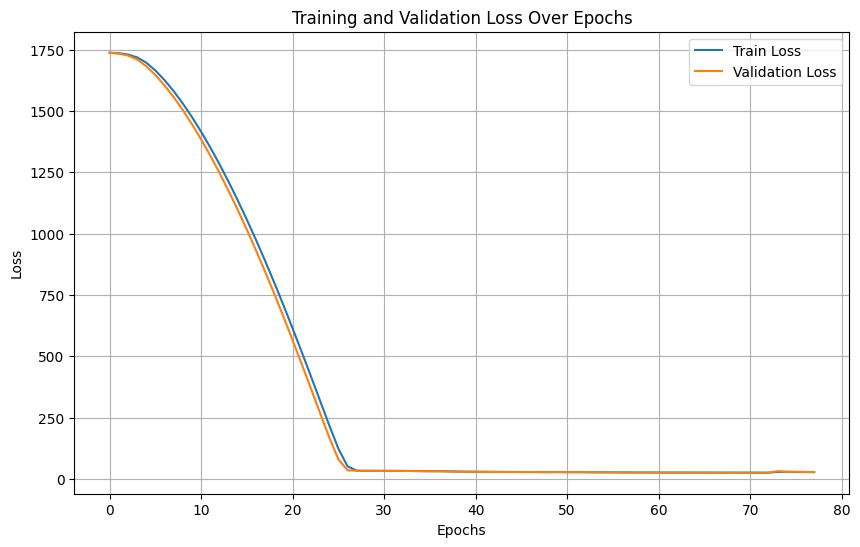

In [24]:
#Run this cell if you want to start the training
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000, patience=5, device=device)

# COMPARISON OF THE FEATURES OF A SECTIN OF THE MAP

/tmp/ipykernel_36/3742354971.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/models/pytorch/default/3/VIT_32_g500.pth'))

Original input shape: torch.Size([32, 42, 32, 64])
Predicted value for sample 0 at latitude index 2 and longitude index 26: [48619.777]
Actual value for sample 0 at latitude index 2 and longitude index 26: [47776.156]


Predicted value for sample 1 at latitude index 2 and longitude index 26: [48228.74]
Actual value for sample 1 at latitude index 2 and longitude index 26: [49935.42]


Predicted value for sample 2 at latitude index 2 and longitude index 26: [49189.44]
Actual value for sample 2 at latitude index 2 and longitude index 26: [47793.88]


Predicted value for sample 3 at latitude index 2 and longitude index 26: [48407.1]
Actual value for sample 3 at latitude index 2 and longitude index 26: [47408.797]


Predicted value for sample 4 at latitude index 2 and longitude index 26: [48207.984]
Actual value for sample 4 at latitude index 2 and longitude index 26: [48993.066]


Predicted value for sample 5 at latitude index 2 and longitude index 26: [48686.453]
Actual value for sample 5

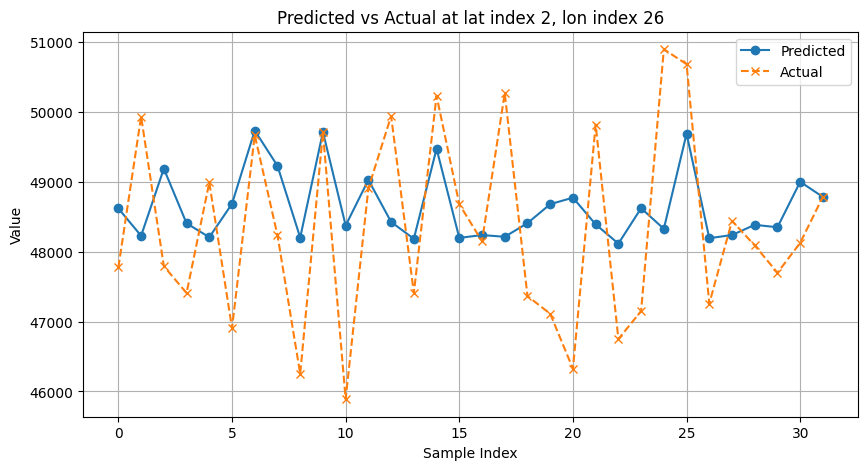

In [62]:
#Run this cell
#As before select the model that you want to run to see the results
# Initialize the model and load weights
# model = ResNet()  
#model.load_state_dict(torch.load('/kaggle/working/best_model.pth', map_location=torch.device('cpu')))
model = UNet() 
#model = ResNet()
#model = VisionTransformer().to(device)
#model = ResNet1()

# Load the model state_dict of the model you want to see (default UNet)
model.load_state_dict(torch.load('/kaggle/input/models/pytorch/default/3/Unet_32_t2m.pth'))
model.to(device)
model.eval()

data_iter = iter(test_loader)
batch_num = 1 

# Retrieve the desired batch
for _ in range(batch_num):
    inputs, labels = next(data_iter)

inputs, labels = inputs.to(device), labels.to(device)

print(f"Original input shape: {inputs.shape}")

# Define latitude and longitude indices
latitude_index = 2
longitude_index = 26

# Make prediction for the entire batch
with torch.no_grad():
    predicted_output = model(inputs)

# Initialize lists to accumulate all predicted and actual values across the batch
all_predicted_values = []
all_actual_values = []

# Iterate over the batch to collect predicted vs actual values for each sample
for i in range(predicted_output.shape[0]):
    # Extract the predicted values for the specified latitude and longitude
    predicted_values = predicted_output[i, :, latitude_index, longitude_index].cpu().numpy()
    print(f"Predicted value for sample {i} at latitude index {latitude_index} and longitude index {longitude_index}: {predicted_values}")
    all_predicted_values.append(predicted_values)
    
    # Extract the actual values for the specified latitude and longitude
    actual_values = labels[i, :, latitude_index, longitude_index].cpu().numpy()
    all_actual_values.append(actual_values)
    print(f"Actual value for sample {i} at latitude index {latitude_index} and longitude index {longitude_index}: {actual_values}")
    print("\n")

all_predicted_values = np.array(all_predicted_values).flatten()
all_actual_values = np.array(all_actual_values).flatten()

plt.figure(figsize=(10, 5))
plt.plot(all_predicted_values, label='Predicted', marker='o', linestyle='-')
plt.plot(all_actual_values, label='Actual', marker='x', linestyle='--')
plt.title(f'Predicted vs Actual at lat index {latitude_index}, lon index {longitude_index}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# ITERATIVE FORECASTING

In [4]:
file_path = '/kaggle/input/tensor/tensor.npy'

# Load the .npy file into a NumPy array
reshaped_data = np.load(file_path)

reshaped_data = reshaped_data[:18000]
# Check the shape of the loaded data
print("Data shape:", reshaped_data.shape)

Data shape: (18000, 13, 32, 64)


In [5]:
def prepare_data_for_iterative_forecasting(data, lead_time):
    inputs = []
    targets = []
    
    for i in range(len(data) - lead_time):
        # Convert numpy array to torch tensor
        inputs.append(torch.tensor(data[i], dtype=torch.float32))
        targets.append(torch.tensor(data[i + lead_time], dtype=torch.float32))
    
    return torch.stack(inputs), torch.stack(targets)

# Prepare data with lead_time=1 (6 hours ahead if each sample represents 6 hours)
inputs, targets = prepare_data_for_iterative_forecasting(reshaped_data, lead_time=6)
print(inputs.shape)
print(targets.shape)

torch.Size([17994, 13, 32, 64])
torch.Size([17994, 13, 32, 64])


In [13]:
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(inputs, targets)

# Split the dataset into training, validation, and testing (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for each split
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# UNET FOR ITERATIVE

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=13):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            return block
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder path
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, 64)
        
        # Final layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final layer
        output = self.final_conv(dec1)
        
        return output

# ADJUSTED LOSS FOR ITERATIVE

In [9]:
def latitude_weighted_rmse1(y_pred, y_true, latitudes):
    L = latitude_weighting(latitudes).to(y_true.device)
    L = L[None, None, :, None]  # Shape: (1, 1, H, 1)
    diff = y_pred - y_true
    weighted_mse = torch.sum(torch.sum(L * (diff ** 2), dim=2),dim=2) /  (y_true.size(2) * y_true.size(3))
    rmse = (1/y_true.size(0)) * torch.sum(torch.sqrt(weighted_mse),dim=0)
    loss = 1/y_true.size(1)*torch.sum(rmse)
    return loss

# TRAIN ITERATIVE

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load('/kaggle/input/models/pytorch/default/3/Iterative.pth'))

criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = WarmUpLR(optimizer, warmup_epochs=5, total_epochs=100)

# Train the model
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000, patience=5, device=device)

/tmp/ipykernel_716/4104680914.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/models/pytorch/default/3/Iterative.pth'))


# PLOT RESULTS

In [16]:
def iterative_forecasting(model, initial_input, num_iterations, device='cpu'):
    model.eval()
    forecasts = []
    current_input = initial_input.to(device)

    if current_input.size(1) == 1:
        current_input = current_input.repeat(1, 13, 1, 1)  # Example: repeat to match 13 channels
    
    with torch.no_grad():
        for _ in range(num_iterations):
            forecast = model(current_input)
            forecasts.append(forecast)
            current_input = forecast  # Feed the output back as input

    return torch.stack(forecasts, dim=1)


initial_input = next(iter(test_loader))[0].to(device)
num_iterations = 3  # Number of steps to forecast

# Perform iterative forecasting
iterative_forecasts = iterative_forecasting(model, initial_input, num_iterations, device=device)

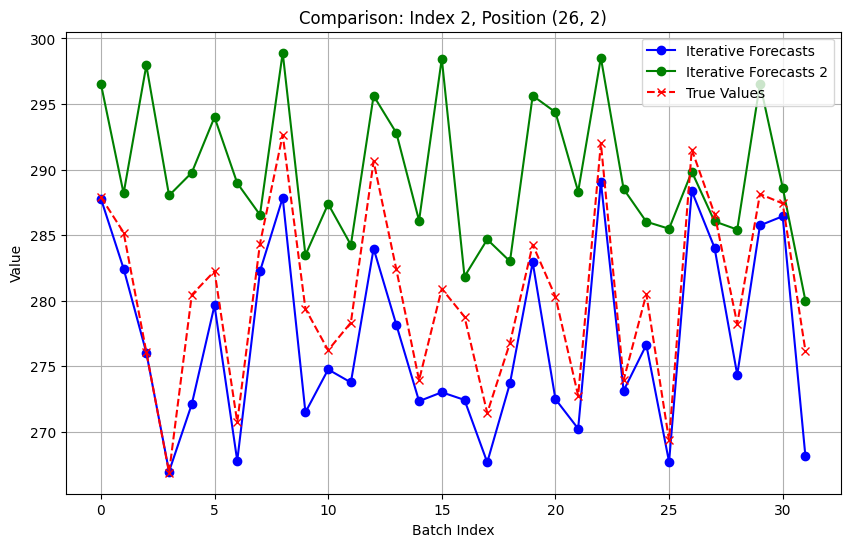

In [18]:
index = 2
pos1 = 26
pos2 = 2

for inputs, labels in test_loader:
    break
    
# Extract data
data1 = iterative_forecasts[:, 0, index, pos1, pos2].cpu().numpy()
data12 = iterative_forecasts[:, 1, index, pos1, pos2].cpu().numpy()
data2 = labels[:, index, pos1, pos2].cpu().numpy() 

plt.figure(figsize=(10, 6))
plt.plot(data1, marker='o', linestyle='-', color='b', label='Iterative Forecasts')
plt.plot(data12, marker='o', linestyle='-', color='g', label='Iterative Forecasts 2')
plt.plot(data2, marker='x', linestyle='--', color='r', label='True Values')
plt.title(f'Comparison: Index {index}, Position ({pos1}, {pos2})')
plt.xlabel('Batch Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# CONTINUOUS FORECASTING

In [4]:
time_steps = reshaped_data.shape[0]  # Total time steps

# Define the time step offsets
t_offsets = [0, 6, 12]  # Offsets for t, t-6h, t-12h
t_plus_24h = 24         # Offset for t+24h

X, y = [], []

# Create sequences and corresponding labels
for i in range(time_steps - t_plus_24h):
    sequence = np.concatenate([reshaped_data[i - offset] for offset in t_offsets], axis=0)
    
    if (i + t_plus_24h) < time_steps:
        if reshaped_data[i + t_plus_24h].shape[0] >= 3:
            # Initialize a list to collect labels for the next 24 hours
            labels = []
            for j in range(0, 24):
                label = reshaped_data[i + j][2, :, :]
                labels.append(label)
            
            # Stack the collected labels to form the final label tensor for this sequence
            labels = np.stack(labels, axis=0)  
            
            X.append(sequence)
            y.append(labels)

X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)  # Expected: (num_sequences, 39, 32, 64)
print("y shape:", y.shape)

X shape: (17976, 39, 32, 64)
y shape: (17976, 24, 32, 64)


In [ ]:
base_path_c = '/kaggle/input/constants/constants/constants.nc'

dataset_c = nc.Dataset(base_path_c, 'r')
oro = dataset_c.variables['orography'][:]
lat = dataset_c.variables['lat'][:]
lsm = dataset_c.variables['lsm'][:]

lat_expanded = np.tile(lat[:, np.newaxis], (1, 64))

print("Orography shape:", oro.shape)          # (32, 64)
print("Lat expanded shape:", lat_expanded.shape)  # (32, 64)
print("Land-sea mask shape:", lsm.shape)      # (32, 64)

oro_expanded = np.tile(oro[np.newaxis, :, :], (X.shape[0], 1, 1))
lat_expanded = np.tile(lat_expanded[np.newaxis, :, :], (X.shape[0], 1, 1))
lsm_expanded = np.tile(lsm[np.newaxis, :, :], (X.shape[0], 1, 1))

X = np.concatenate([X, oro_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lat_expanded[:, np.newaxis, :, :]], axis=1)
X = np.concatenate([X, lsm_expanded[:, np.newaxis, :, :]], axis=1)


del oro_expanded
del lat_expanded
del lsm_expanded

X = np.ma.filled(X, np.nan)


print("Data shape:", X.shape)

Orography shape: (32, 64)
Lat expanded shape: (32, 64)
Land-sea mask shape: (32, 64)


In [5]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# First, split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)

del X
del y

gc.collect()

# Then split the temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

In [14]:
batch_size = 32
train_dataset = ClimateDataset(X_train, y_train)
val_dataset = ClimateDataset(X_val, y_val)
test_dataset = ClimateDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# UNET FOR CONTINUOUS 

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=39, out_channels=24):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            return block
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder path
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, 64)
        
        # Final layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final layer
        output = self.final_conv(dec1)
        
        return output

# ADJUSTED LOSS FOR CONTINUOUS

In [16]:
def latitude_weighted_rmse2(y_pred, y_true, latitudes):
    L = latitude_weighting(latitudes).to(y_true.device)
    L = L[None, None, :, None]
    # Compute the difference and apply latitude weighting
    diff = y_pred - y_true
    weighted_mse = torch.sum(torch.sum(L * (diff ** 2), dim=2),dim=2) /  (y_true.size(2) * y_true.size(3))
    rmse = (1/y_true.size(0)) * torch.sum(torch.sqrt(weighted_mse),dim=0)
    loss = 1/y_true.size(1)*torch.sum(rmse)
    return loss

# TRAIN CONTINUOUS

Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.09batch/s]


Epoch 1/1000 - Train Loss: 8.9003 - Train ACC: 0.0001 - Val Loss: 76349.6702 - Val RMSE: 8.8605 - Val ACC: 0.0001


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.96batch/s]


Epoch 2/1000 - Train Loss: 8.7584 - Train ACC: 0.0002 - Val Loss: 73417.3135 - Val RMSE: 8.6382 - Val ACC: 0.0002


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.16batch/s]


Epoch 3/1000 - Train Loss: 8.4214 - Train ACC: 0.0006 - Val Loss: 67409.3176 - Val RMSE: 8.1696 - Val ACC: 0.0010


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.67batch/s]


Epoch 4/1000 - Train Loss: 7.7630 - Train ACC: 0.0014 - Val Loss: 57165.0418 - Val RMSE: 7.3071 - Val ACC: 0.0021


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.98batch/s]


Epoch 5/1000 - Train Loss: 6.6481 - Train ACC: 0.0033 - Val Loss: 42896.1628 - Val RMSE: 5.9350 - Val ACC: 0.0050


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.00batch/s]


Epoch 6/1000 - Train Loss: 5.2313 - Train ACC: 0.0071 - Val Loss: 30727.4054 - Val RMSE: 4.5294 - Val ACC: 0.0092


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.08batch/s]


Epoch 7/1000 - Train Loss: 3.6853 - Train ACC: 0.0139 - Val Loss: 12918.1055 - Val RMSE: 2.1953 - Val ACC: 0.0227


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.12batch/s]


Epoch 8/1000 - Train Loss: 1.5459 - Train ACC: 0.0691 - Val Loss: 8017.9475 - Val RMSE: 1.1678 - Val ACC: 0.0963


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.15batch/s]


Epoch 9/1000 - Train Loss: 1.1066 - Train ACC: 0.1161 - Val Loss: 7647.1264 - Val RMSE: 1.0819 - Val ACC: 0.1251


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.18batch/s]


Epoch 10/1000 - Train Loss: 1.0782 - Train ACC: 0.1264 - Val Loss: 7624.7201 - Val RMSE: 1.0771 - Val ACC: 0.1324


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 11/1000 - Train Loss: 0.5725 - Train ACC: 0.3083 - Val Loss: 225.7768 - Val RMSE: 0.1936 - Val ACC: 0.6020


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.07batch/s]


Epoch 12/1000 - Train Loss: 0.1124 - Train ACC: 0.8172 - Val Loss: 11.7173 - Val RMSE: 0.0904 - Val ACC: 0.8800


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 13/1000 - Train Loss: 0.0836 - Train ACC: 0.8963 - Val Loss: 9.4144 - Val RMSE: 0.0810 - Val ACC: 0.9033


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.95batch/s]


Epoch 14/1000 - Train Loss: 0.0769 - Train ACC: 0.9125 - Val Loss: 9.1736 - Val RMSE: 0.0816 - Val ACC: 0.9032


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.10batch/s]


Epoch 15/1000 - Train Loss: 0.0707 - Train ACC: 0.9269 - Val Loss: 7.3378 - Val RMSE: 0.0721 - Val ACC: 0.9247


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.37batch/s]


Epoch 16/1000 - Train Loss: 0.0662 - Train ACC: 0.9359 - Val Loss: 7.3794 - Val RMSE: 0.0687 - Val ACC: 0.9322


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.66batch/s]


Epoch 17/1000 - Train Loss: 0.0625 - Train ACC: 0.9435 - Val Loss: 5.9384 - Val RMSE: 0.0625 - Val ACC: 0.9434


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.48batch/s]


Epoch 18/1000 - Train Loss: 0.0603 - Train ACC: 0.9474 - Val Loss: 5.6427 - Val RMSE: 0.0609 - Val ACC: 0.9466


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 19/1000 - Train Loss: 0.0582 - Train ACC: 0.9510 - Val Loss: 5.4873 - Val RMSE: 0.0609 - Val ACC: 0.9470


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.73batch/s]


Epoch 20/1000 - Train Loss: 0.0563 - Train ACC: 0.9542 - Val Loss: 4.6652 - Val RMSE: 0.0559 - Val ACC: 0.9551


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.70batch/s]


Epoch 21/1000 - Train Loss: 0.0549 - Train ACC: 0.9566 - Val Loss: 15.2490 - Val RMSE: 0.0961 - Val ACC: 0.8507


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.13batch/s]


Epoch 22/1000 - Train Loss: 0.0542 - Train ACC: 0.9575 - Val Loss: 4.3480 - Val RMSE: 0.0543 - Val ACC: 0.9575


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.14batch/s]


Epoch 23/1000 - Train Loss: 0.0515 - Train ACC: 0.9619 - Val Loss: 3.8180 - Val RMSE: 0.0516 - Val ACC: 0.9618


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.76batch/s]


Epoch 24/1000 - Train Loss: 0.0502 - Train ACC: 0.9639 - Val Loss: 4.3259 - Val RMSE: 0.0571 - Val ACC: 0.9543


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.49batch/s]


Epoch 25/1000 - Train Loss: 0.0489 - Train ACC: 0.9657 - Val Loss: 3.6769 - Val RMSE: 0.0506 - Val ACC: 0.9635


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 26/1000 - Train Loss: 0.0479 - Train ACC: 0.9672 - Val Loss: 3.3895 - Val RMSE: 0.0491 - Val ACC: 0.9655


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.14batch/s]


Epoch 27/1000 - Train Loss: 0.0468 - Train ACC: 0.9686 - Val Loss: 4.1248 - Val RMSE: 0.0532 - Val ACC: 0.9595


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 28/1000 - Train Loss: 0.0457 - Train ACC: 0.9701 - Val Loss: 3.0729 - Val RMSE: 0.0474 - Val ACC: 0.9679


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 29/1000 - Train Loss: 0.0450 - Train ACC: 0.9710 - Val Loss: 3.0216 - Val RMSE: 0.0462 - Val ACC: 0.9695


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.73batch/s]


Epoch 30/1000 - Train Loss: 0.0440 - Train ACC: 0.9722 - Val Loss: 2.9302 - Val RMSE: 0.0467 - Val ACC: 0.9688


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.99batch/s]


Epoch 31/1000 - Train Loss: 0.0431 - Train ACC: 0.9734 - Val Loss: 3.5460 - Val RMSE: 0.0485 - Val ACC: 0.9667


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 32/1000 - Train Loss: 0.0425 - Train ACC: 0.9742 - Val Loss: 2.6435 - Val RMSE: 0.0442 - Val ACC: 0.9721


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.92batch/s]


Epoch 33/1000 - Train Loss: 0.0415 - Train ACC: 0.9754 - Val Loss: 2.4341 - Val RMSE: 0.0419 - Val ACC: 0.9750


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.09batch/s]


Epoch 34/1000 - Train Loss: 0.0409 - Train ACC: 0.9760 - Val Loss: 2.6060 - Val RMSE: 0.0453 - Val ACC: 0.9709


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.20batch/s]


Epoch 35/1000 - Train Loss: 0.0403 - Train ACC: 0.9768 - Val Loss: 2.2298 - Val RMSE: 0.0404 - Val ACC: 0.9767


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 36/1000 - Train Loss: 0.0394 - Train ACC: 0.9778 - Val Loss: 2.0928 - Val RMSE: 0.0388 - Val ACC: 0.9785


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.14batch/s]


Epoch 37/1000 - Train Loss: 0.0389 - Train ACC: 0.9784 - Val Loss: 2.1871 - Val RMSE: 0.0398 - Val ACC: 0.9773


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.69batch/s]


Epoch 38/1000 - Train Loss: 0.0381 - Train ACC: 0.9793 - Val Loss: 2.7445 - Val RMSE: 0.0448 - Val ACC: 0.9723


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.88batch/s]


Epoch 39/1000 - Train Loss: 0.0376 - Train ACC: 0.9799 - Val Loss: 1.9491 - Val RMSE: 0.0382 - Val ACC: 0.9792


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.55batch/s]


Epoch 40/1000 - Train Loss: 0.0370 - Train ACC: 0.9804 - Val Loss: 1.8700 - Val RMSE: 0.0370 - Val ACC: 0.9804


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 41/1000 - Train Loss: 0.0366 - Train ACC: 0.9809 - Val Loss: 1.8542 - Val RMSE: 0.0365 - Val ACC: 0.9810


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 42/1000 - Train Loss: 0.0362 - Train ACC: 0.9813 - Val Loss: 2.0623 - Val RMSE: 0.0389 - Val ACC: 0.9784


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.75batch/s]


Epoch 43/1000 - Train Loss: 0.0356 - Train ACC: 0.9819 - Val Loss: 1.7156 - Val RMSE: 0.0359 - Val ACC: 0.9816


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.15batch/s]


Epoch 44/1000 - Train Loss: 0.0353 - Train ACC: 0.9822 - Val Loss: 1.9380 - Val RMSE: 0.0367 - Val ACC: 0.9808


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.31batch/s]


Epoch 45/1000 - Train Loss: 0.0349 - Train ACC: 0.9826 - Val Loss: 1.7014 - Val RMSE: 0.0354 - Val ACC: 0.9821


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.00batch/s]


Epoch 46/1000 - Train Loss: 0.0345 - Train ACC: 0.9830 - Val Loss: 1.6960 - Val RMSE: 0.0349 - Val ACC: 0.9827


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.07batch/s]


Epoch 47/1000 - Train Loss: 0.0341 - Train ACC: 0.9833 - Val Loss: 1.7450 - Val RMSE: 0.0353 - Val ACC: 0.9822


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.70batch/s]


Epoch 48/1000 - Train Loss: 0.0337 - Train ACC: 0.9838 - Val Loss: 1.6493 - Val RMSE: 0.0346 - Val ACC: 0.9829


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.88batch/s]


Epoch 49/1000 - Train Loss: 0.0335 - Train ACC: 0.9840 - Val Loss: 1.6549 - Val RMSE: 0.0352 - Val ACC: 0.9823


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 23.94batch/s]


Epoch 50/1000 - Train Loss: 0.0332 - Train ACC: 0.9842 - Val Loss: 1.5680 - Val RMSE: 0.0336 - Val ACC: 0.9839


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.82batch/s]


Epoch 51/1000 - Train Loss: 0.0328 - Train ACC: 0.9846 - Val Loss: 1.4941 - Val RMSE: 0.0329 - Val ACC: 0.9845


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.67batch/s]


Epoch 52/1000 - Train Loss: 0.0326 - Train ACC: 0.9848 - Val Loss: 1.5310 - Val RMSE: 0.0337 - Val ACC: 0.9838


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.94batch/s]


Epoch 53/1000 - Train Loss: 0.0323 - Train ACC: 0.9850 - Val Loss: 1.4863 - Val RMSE: 0.0328 - Val ACC: 0.9847


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 54/1000 - Train Loss: 0.0321 - Train ACC: 0.9853 - Val Loss: 1.5968 - Val RMSE: 0.0353 - Val ACC: 0.9823


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.24batch/s]


Epoch 55/1000 - Train Loss: 0.0319 - Train ACC: 0.9854 - Val Loss: 1.4608 - Val RMSE: 0.0324 - Val ACC: 0.9850


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 56/1000 - Train Loss: 0.0316 - Train ACC: 0.9857 - Val Loss: 1.4610 - Val RMSE: 0.0323 - Val ACC: 0.9852


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.04batch/s]


Epoch 57/1000 - Train Loss: 0.0314 - Train ACC: 0.9859 - Val Loss: 1.4425 - Val RMSE: 0.0323 - Val ACC: 0.9851


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.65batch/s]


Epoch 58/1000 - Train Loss: 0.0312 - Train ACC: 0.9861 - Val Loss: 1.4052 - Val RMSE: 0.0320 - Val ACC: 0.9854


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.89batch/s]


Epoch 59/1000 - Train Loss: 0.0310 - Train ACC: 0.9863 - Val Loss: 1.4156 - Val RMSE: 0.0316 - Val ACC: 0.9858


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 60/1000 - Train Loss: 0.0307 - Train ACC: 0.9865 - Val Loss: 1.3800 - Val RMSE: 0.0313 - Val ACC: 0.9860


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.48batch/s]


Epoch 61/1000 - Train Loss: 0.0305 - Train ACC: 0.9867 - Val Loss: 1.2905 - Val RMSE: 0.0306 - Val ACC: 0.9866


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.02batch/s]


Epoch 62/1000 - Train Loss: 0.0303 - Train ACC: 0.9868 - Val Loss: 1.4305 - Val RMSE: 0.0321 - Val ACC: 0.9853


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.78batch/s]


Epoch 63/1000 - Train Loss: 0.0301 - Train ACC: 0.9870 - Val Loss: 1.3641 - Val RMSE: 0.0312 - Val ACC: 0.9861


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.75batch/s]


Epoch 64/1000 - Train Loss: 0.0299 - Train ACC: 0.9872 - Val Loss: 1.2463 - Val RMSE: 0.0299 - Val ACC: 0.9872


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.87batch/s]


Epoch 65/1000 - Train Loss: 0.0297 - Train ACC: 0.9873 - Val Loss: 1.2494 - Val RMSE: 0.0299 - Val ACC: 0.9872


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 66/1000 - Train Loss: 0.0296 - Train ACC: 0.9875 - Val Loss: 1.2426 - Val RMSE: 0.0297 - Val ACC: 0.9874


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.85batch/s]


Epoch 67/1000 - Train Loss: 0.0294 - Train ACC: 0.9876 - Val Loss: 1.3045 - Val RMSE: 0.0311 - Val ACC: 0.9862


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.04batch/s]


Epoch 68/1000 - Train Loss: 0.0293 - Train ACC: 0.9877 - Val Loss: 1.2318 - Val RMSE: 0.0295 - Val ACC: 0.9876


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.84batch/s]


Epoch 69/1000 - Train Loss: 0.0291 - Train ACC: 0.9878 - Val Loss: 1.2187 - Val RMSE: 0.0294 - Val ACC: 0.9876


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.97batch/s]


Epoch 70/1000 - Train Loss: 0.0290 - Train ACC: 0.9880 - Val Loss: 1.2042 - Val RMSE: 0.0292 - Val ACC: 0.9878


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.92batch/s]


Epoch 71/1000 - Train Loss: 0.0289 - Train ACC: 0.9881 - Val Loss: 1.1931 - Val RMSE: 0.0291 - Val ACC: 0.9879


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.64batch/s]


Epoch 72/1000 - Train Loss: 0.0287 - Train ACC: 0.9881 - Val Loss: 1.2467 - Val RMSE: 0.0298 - Val ACC: 0.9873


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.80batch/s]


Epoch 73/1000 - Train Loss: 0.0286 - Train ACC: 0.9883 - Val Loss: 1.1766 - Val RMSE: 0.0289 - Val ACC: 0.9881


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.98batch/s]


Epoch 74/1000 - Train Loss: 0.0285 - Train ACC: 0.9883 - Val Loss: 1.1495 - Val RMSE: 0.0286 - Val ACC: 0.9883


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.97batch/s]


Epoch 75/1000 - Train Loss: 0.0284 - Train ACC: 0.9884 - Val Loss: 1.1382 - Val RMSE: 0.0285 - Val ACC: 0.9884


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.83batch/s]


Epoch 76/1000 - Train Loss: 0.0283 - Train ACC: 0.9885 - Val Loss: 1.1451 - Val RMSE: 0.0286 - Val ACC: 0.9883


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.72batch/s]


Epoch 77/1000 - Train Loss: 0.0282 - Train ACC: 0.9886 - Val Loss: 1.1432 - Val RMSE: 0.0286 - Val ACC: 0.9883


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.74batch/s]


Epoch 78/1000 - Train Loss: 0.0281 - Train ACC: 0.9886 - Val Loss: 1.1422 - Val RMSE: 0.0285 - Val ACC: 0.9884


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.02batch/s]


Epoch 79/1000 - Train Loss: 0.0280 - Train ACC: 0.9887 - Val Loss: 1.1145 - Val RMSE: 0.0281 - Val ACC: 0.9887


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 80/1000 - Train Loss: 0.0280 - Train ACC: 0.9888 - Val Loss: 1.1159 - Val RMSE: 0.0282 - Val ACC: 0.9886


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.63batch/s]


Epoch 81/1000 - Train Loss: 0.0279 - Train ACC: 0.9888 - Val Loss: 1.1230 - Val RMSE: 0.0283 - Val ACC: 0.9885


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 82/1000 - Train Loss: 0.0278 - Train ACC: 0.9889 - Val Loss: 1.0955 - Val RMSE: 0.0281 - Val ACC: 0.9887


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.78batch/s]


Epoch 83/1000 - Train Loss: 0.0277 - Train ACC: 0.9890 - Val Loss: 1.0846 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.99batch/s]


Epoch 84/1000 - Train Loss: 0.0277 - Train ACC: 0.9890 - Val Loss: 1.0851 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.15batch/s]


Epoch 85/1000 - Train Loss: 0.0276 - Train ACC: 0.9891 - Val Loss: 1.0812 - Val RMSE: 0.0278 - Val ACC: 0.9890


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 86/1000 - Train Loss: 0.0276 - Train ACC: 0.9891 - Val Loss: 1.0821 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 87/1000 - Train Loss: 0.0275 - Train ACC: 0.9891 - Val Loss: 1.0824 - Val RMSE: 0.0279 - Val ACC: 0.9889


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.94batch/s]


Epoch 88/1000 - Train Loss: 0.0275 - Train ACC: 0.9892 - Val Loss: 1.0678 - Val RMSE: 0.0276 - Val ACC: 0.9891


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.04batch/s]


Epoch 89/1000 - Train Loss: 0.0275 - Train ACC: 0.9891 - Val Loss: 1.0696 - Val RMSE: 0.0277 - Val ACC: 0.9890


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.90batch/s]


Epoch 90/1000 - Train Loss: 0.0274 - Train ACC: 0.9892 - Val Loss: 1.0663 - Val RMSE: 0.0276 - Val ACC: 0.9891


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.30batch/s]


Epoch 91/1000 - Train Loss: 0.0274 - Train ACC: 0.9893 - Val Loss: 1.0579 - Val RMSE: 0.0275 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.69batch/s]


Epoch 92/1000 - Train Loss: 0.0273 - Train ACC: 0.9892 - Val Loss: 1.0624 - Val RMSE: 0.0275 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.97batch/s]


Epoch 93/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0561 - Val RMSE: 0.0275 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.95batch/s]


Epoch 94/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0553 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.91batch/s]


Epoch 95/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0565 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.13batch/s]


Epoch 96/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0511 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.86batch/s]


Epoch 97/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0536 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.75batch/s]


Epoch 98/1000 - Train Loss: 0.0272 - Train ACC: 0.9894 - Val Loss: 1.0519 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.95batch/s]


Epoch 99/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0511 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.94batch/s]


Epoch 100/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0512 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.58batch/s]


Epoch 101/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0529 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.71batch/s]


Epoch 102/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0513 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.92batch/s]


Epoch 103/1000 - Train Loss: 0.0272 - Train ACC: 0.9894 - Val Loss: 1.0504 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 25.00batch/s]


Epoch 104/1000 - Train Loss: 0.0272 - Train ACC: 0.9893 - Val Loss: 1.0532 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.74batch/s]


Epoch 105/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0547 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.88batch/s]


Epoch 106/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0550 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.72batch/s]


Epoch 107/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0516 - Val RMSE: 0.0274 - Val ACC: 0.9892


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.90batch/s]
/tmp/ipykernel_102/121138544.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

Epoch 108/1000 - Train Loss: 0.0273 - Train ACC: 0.9893 - Val Loss: 1.0529 - Val RMSE: 0.0274 - Val ACC: 0.9892
Early stopping


Evaluating: 100%|██████████| 85/85 [00:03<00:00, 24.57batch/s]


Test Loss: 1.0437 - Test RMSE: 0.0274 - Test ACC: 0.9893
Total Training Time: 4064.13 seconds


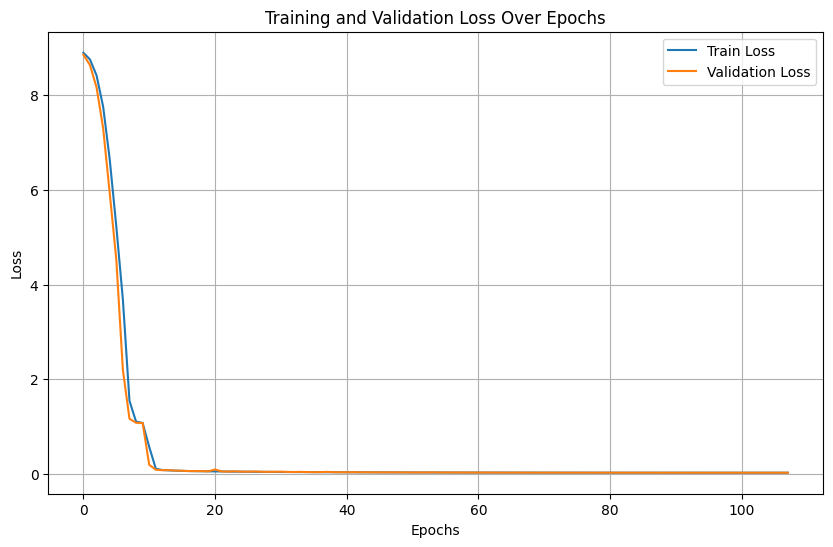

In [14]:
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000, patience=5, device=device)

In [17]:
model = UNet().to(device)
model.load_state_dict(torch.load('/kaggle/input/models/pytorch/default/3/Continuos.pth'))

/tmp/ipykernel_872/2128761557.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/models/pytorch/default/3/Continuos.pth'))


<All keys matched successfully>

# SHOW RESULTS

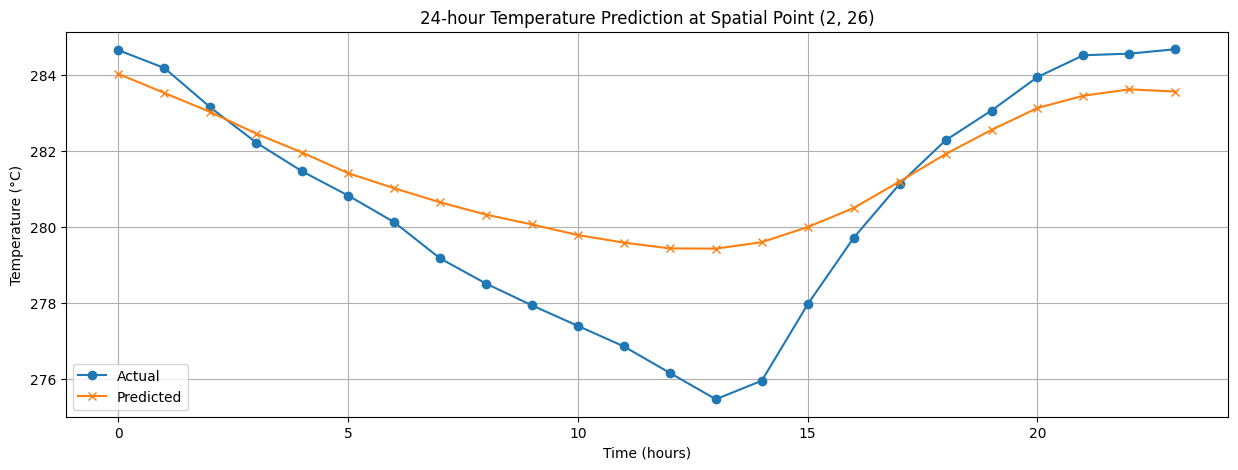

In [24]:
sample_index = 0
input_sequence = torch.tensor(X_test[sample_index:sample_index+1], dtype=torch.float32)
input_sequence = input_sequence.to(next(model.parameters()).device)

# Generate prediction using your model
predicted_output = model(input_sequence)  # Output shape should be (1, 24, 32, 64)

# Remove the batch dimension (from shape (1, 24, 32, 64) to (24, 32, 64))
predicted_output = predicted_output.squeeze(0).cpu().detach().numpy()
actual_output = y_test[sample_index]

plt.figure(figsize=(15, 5))

# Select a specific spatial point
x, y = 26,2

plt.plot(range(24), actual_output[:, x, y], label='Actual', marker='o')
plt.plot(range(24), predicted_output[:, x, y], label='Predicted', marker='x')
plt.title('24-hour Temperature Prediction at Spatial Point (2, 26)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')  # Adjust the unit accordingly
plt.legend()
plt.grid(True)
plt.show()